In [1]:
# Standard
import math, time, random
import numpy as np

# Data & utilities
from sklearn.datasets import load_digits, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting (optional)
import matplotlib.pyplot as plt

np.random.seed(42)

In [7]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

MNIST_TRAIN_IMAGES = "/content/drive/MyDrive/train-images-idx3-ubyte/train-images-idx3-ubyte"
MNIST_TRAIN_LABELS = "/content/drive/MyDrive/train-labels-idx1-ubyte/train-labels-idx1-ubyte"
MNIST_TEST_IMAGES  = "/content/drive/MyDrive/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
MNIST_TEST_LABELS  = "/content/drive/MyDrive/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"


Mounted at /content/drive


### Reading and Preparing the MNIST Dataset

The MNIST dataset is stored in the **IDX file format**, which encodes images and labels in binary form. To read these files, we define helper functions:

- **`read_idx_images(path)`**  
  Opens the image file (supports both raw and `.gz` compressed files), checks the magic number for validation, then reads the number of images, rows, and columns. The pixel values are loaded into a NumPy array of shape `(n_samples, rows, cols)`.

- **`read_idx_labels(path)`**  
  Opens the label file, checks its magic number, then reads the label values into a NumPy array of shape `(n_samples,)`.

Using these functions, we load the training and test sets:
- Training set: `Xtr` (60,000 images of shape 28×28) and `ytr` (labels 0–9).  
- Test set: `Xte` (10,000 images of shape 28×28) and `yte`.

---

### Preprocessing

1. **Flattening and Scaling**  
   Each 28×28 image is reshaped into a 1D vector of 784 pixels, and pixel values are normalized to the range `[0,1]`.

2. **Validation Split**  
   A random 10,000-sample subset of the training set is separated as a validation set.  
   - `X_train, y_train`: training data  
   - `X_val, y_val`: validation data  
   - `X_test, y_test`: test data  

3. **Dataset Statistics**  
   The final shapes are printed along with the number of unique classes:
   - `X_train.shape`, `X_val.shape`, `X_test.shape`  
   - Number of output classes (`num_classes = 10` for digits 0–9).

This setup ensures the data is ready for training machine learning models.


choosing the dataset

In [8]:
import gzip
import os

def _from_bytes(f, count, dtype=np.uint8):
    """Read count items from file-like object f (supports raw or .gz)."""
    data = f.read(count)
    return np.frombuffer(data, dtype=dtype)

def read_idx_images(path):
    # supports raw or .gz
    opener = gzip.open if path.endswith(".gz") else open
    with opener(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        assert magic == 2051, f"Bad magic for images: {magic}"
        n    = int.from_bytes(f.read(4), "big")
        rows = int.from_bytes(f.read(4), "big")
        cols = int.from_bytes(f.read(4), "big")
        buf  = f.read(n * rows * cols)
        X = np.frombuffer(buf, dtype=np.uint8).reshape(n, rows, cols)
        return X

def read_idx_labels(path):
    opener = gzip.open if path.endswith(".gz") else open
    with opener(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        assert magic == 2049, f"Bad magic for labels: {magic}"
        n     = int.from_bytes(f.read(4), "big")
        y = np.frombuffer(f.read(n), dtype=np.uint8)
        return y

# --- load ---
Xtr = read_idx_images(MNIST_TRAIN_IMAGES)   # (60000, 28, 28)
ytr = read_idx_labels(MNIST_TRAIN_LABELS)   # (60000,)
Xte = read_idx_images(MNIST_TEST_IMAGES)    # (10000, 28, 28)
yte = read_idx_labels(MNIST_TEST_LABELS)    # (10000,)

# flatten + scale to [0,1]
Xtr = Xtr.reshape(len(Xtr), -1).astype(np.float32) / 255.0
Xte = Xte.reshape(len(Xte), -1).astype(np.float32) / 255.0

# make a validation split from training (e.g., 10k for val)
val_ratio = 10000 / len(Xtr)
N = len(Xtr)
perm = np.random.permutation(N)
n_val = int(N * val_ratio)
val_idx, tr_idx = perm[:n_val], perm[n_val:]

X_train, y_train = Xtr[tr_idx], ytr[tr_idx]
X_val,   y_val   = Xtr[val_idx], ytr[val_idx]
X_test,  y_test  = Xte, yte

input_dim   = X_train.shape[1]   # 784
num_classes = len(np.unique(y_train))

print("shapes ->", X_train.shape, X_val.shape, X_test.shape)
print("classes:", num_classes)


shapes -> (50000, 784) (10000, 784) (10000, 784)
classes: 10


### Implementing a Multi-Layer Perceptron (MLP) from Scratch

We now define a simple feedforward neural network (Multi-Layer Perceptron) using **NumPy** only, without deep learning libraries.  
The architecture chosen is:

**Input (784) → Hidden Layer 1 (128, ReLU) → Hidden Layer 2 (64, ReLU) → Output (10, Softmax)**

---

#### Key Components
- **One-hot encoding (`one_hot`)**  
  Converts integer labels into one-hot encoded vectors for cross-entropy loss.

- **Activation Functions**  
  - `ReLU`: Rectified Linear Unit for hidden layers.  
  - `Softmax`: Normalized exponential function for the output layer.

- **MLP Class**  
  - **Initialization** (`__init__`):  
    - Sets up weights (`W1`, `W2`, `W3`) and biases (`b1`, `b2`, `b3`).  
    - Uses **He initialization** for stable gradients in deep networks.  
  - **Forward Pass** (`forward`):  
    - Computes activations through layers and outputs class probabilities.  
  - **Loss & Backpropagation** (`loss_and_grads`):  
    - Uses **cross-entropy loss** with optional L2 regularization.  
    - Implements backpropagation to compute gradients for all layers.  
  - **Parameter Update** (`step`):  
    - Updates weights and biases using gradient descent.

- **Accuracy Function** (`accuracy`)  
  Evaluates the model by checking how many predictions match the true labels.

---

#### Training Dynamics
1. **Forward pass** → compute probabilities.  
2. **Loss computation** → cross-entropy + L2 regularization.  
3. **Backward pass** → gradients of weights & biases via chain rule.  
4. **Update step** → apply gradient descent with learning rate `lr`.  

This provides a fully functional neural network pipeline that can be trained end-to-end on MNIST using only NumPy.


In [9]:
def one_hot(y, C):
    Y = np.zeros((y.shape[0], C), dtype=np.float32)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def softmax(Z):
    Zs = Z - Z.max(axis=1, keepdims=True)
    e  = np.exp(Zs)
    return e / (e.sum(axis=1, keepdims=True) + 1e-12)

def relu(X):  return np.maximum(0, X)
def drelu(X): return (X > 0).astype(np.float32)

class MLP:
    # 784 -> 128 -> 64 -> 10 (you can tweak)
    def __init__(self, input_dim, num_classes, h1=128, h2=64, weight_scale='he'):
        self.shapes = [(input_dim, h1), (h1, h2), (h2, num_classes)]
        self.params = {}
        rng = np.random.default_rng(42)
        for i, (din, dout) in enumerate(self.shapes):
            if weight_scale == 'he':
                W = rng.standard_normal((din, dout), dtype=np.float32) * np.sqrt(2.0/din)
            else:
                W = rng.standard_normal((din, dout), dtype=np.float32) * 0.01
            b = np.zeros((1, dout), dtype=np.float32)
            self.params[f"W{i+1}"] = W
            self.params[f"b{i+1}"] = b

    def forward(self, X):
        W1,b1 = self.params["W1"], self.params["b1"]
        W2,b2 = self.params["W2"], self.params["b2"]
        W3,b3 = self.params["W3"], self.params["b3"]

        Z1 = X @ W1 + b1; A1 = relu(Z1)
        Z2 = A1 @ W2 + b2; A2 = relu(Z2)
        S  = A2 @ W3 + b3
        P  = softmax(S)
        cache = (X, Z1, A1, Z2, A2, S)
        return P, cache

    def loss_and_grads(self, X, y, reg=0.0):
        P, cache = self.forward(X)
        N = X.shape[0]
        Y = one_hot(y, P.shape[1])

        ce = -np.sum(Y * np.log(P + 1e-12)) / N
        l2 = sum(np.sum(self.params[k]**2) for k in ("W1","W2","W3"))
        loss = ce + 0.5 * reg * l2

        X, Z1, A1, Z2, A2, S = cache
        W1, W2, W3 = self.params["W1"], self.params["W2"], self.params["W3"]

        dS  = (softmax(S) - Y) / N
        dW3 = A2.T @ dS + reg * W3
        db3 = dS.sum(axis=0, keepdims=True)

        dA2 = dS @ W3.T
        dZ2 = dA2 * drelu(Z2)
        dW2 = A1.T @ dZ2 + reg * W2
        db2 = dZ2.sum(axis=0, keepdims=True)

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * drelu(Z1)
        dW1 = X.T @ dZ1 + reg * W1
        db1 = dZ1.sum(axis=0, keepdims=True)

        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2, "W3": dW3, "b3": db3}
        return loss, grads

    def step(self, grads, lr):
        for k in self.params:
            self.params[k] -= lr * grads[k]

def accuracy(model, X, y):
    P, _ = model.forward(X)
    return (P.argmax(axis=1) == y).mean()


### Training Loop

We now train the MLP using **mini-batch gradient descent**. The training process involves splitting the data into smaller batches, performing forward and backward passes, and updating the weights iteratively.

---

#### Batch Generator
- **`batches(X, y, bs)`**  
  Yields batches of size `bs` from the dataset.  
  If `shuffle=True`, the data is randomly shuffled each epoch to improve generalization.

---

#### Hyperparameters
- `epochs = 20` → number of training iterations over the dataset.  
- `lr = 0.1` → learning rate for gradient descent.  
- `reg = 1e-4` → L2 regularization strength.  
- `bs = 128` → batch size for mini-batch training.  

---

#### Training Procedure
1. **Epoch Loop**  
   For each epoch:
   - Loop over mini-batches.
   - Compute the **loss and gradients** using backpropagation.
   - Update weights with gradient descent.

2. **Metrics Tracking**  
   - `tr_loss` (training loss)  
   - `val_loss` (validation loss)  
   - `tr_acc` (training accuracy)  
   - `val_acc` (validation accuracy)  

   These values are stored in the `hist` dictionary for later visualization.

3. **Progress Logging**  
   At the first epoch, every 5 epochs, and the final epoch, training statistics are printed in the format:



In [10]:
def batches(X, y, bs, shuffle=True, seed=42):
    N = len(X)
    idx = np.arange(N)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    for s in range(0, N, bs):
        e = min(s+bs, N)
        bi = idx[s:e]
        yield X[bi], y[bi]

# hyperparams
epochs = 20
lr     = 0.1
reg    = 1e-4
bs     = 128

model = MLP(input_dim=input_dim, num_classes=num_classes, h1=128, h2=64)

hist = {"tr_loss":[], "val_loss":[], "tr_acc":[], "val_acc":[]}

for ep in range(1, epochs+1):
    ep_loss_sum, seen = 0.0, 0
    for xb, yb in batches(X_train, y_train, bs, shuffle=True, seed=42+ep):
        loss, grads = model.loss_and_grads(xb, yb, reg)
        model.step(grads, lr)
        ep_loss_sum += loss * len(xb)
        seen += len(xb)
    tr_loss = ep_loss_sum / max(1, seen)

    tr_acc = accuracy(model, X_train, y_train)
    val_loss, _ = model.loss_and_grads(X_val, y_val, reg)
    val_acc = accuracy(model, X_val, y_val)

    hist["tr_loss"].append(tr_loss)
    hist["val_loss"].append(val_loss)
    hist["tr_acc"].append(tr_acc)
    hist["val_acc"].append(val_acc)

    if ep == 1 or ep % 5 == 0 or ep == epochs:
        print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | tr_acc {tr_acc:.3f} | val_acc {val_acc:.3f}")


Epoch 01 | tr_loss 0.4703 | val_loss 0.3062 | tr_acc 0.917 | val_acc 0.915
Epoch 05 | tr_loss 0.1352 | val_loss 0.1446 | tr_acc 0.972 | val_acc 0.964
Epoch 10 | tr_loss 0.0850 | val_loss 0.1229 | tr_acc 0.983 | val_acc 0.970
Epoch 15 | tr_loss 0.0625 | val_loss 0.1066 | tr_acc 0.993 | val_acc 0.975
Epoch 20 | tr_loss 0.0501 | val_loss 0.1009 | tr_acc 0.996 | val_acc 0.978


graph

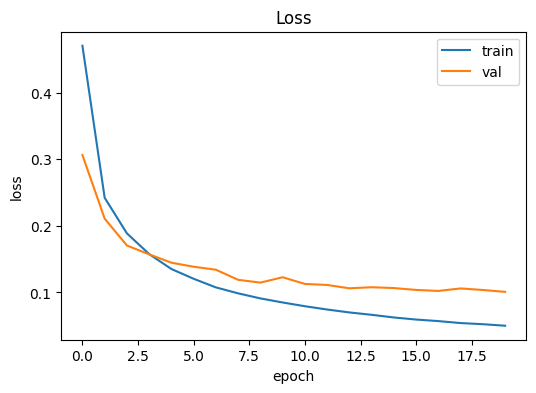

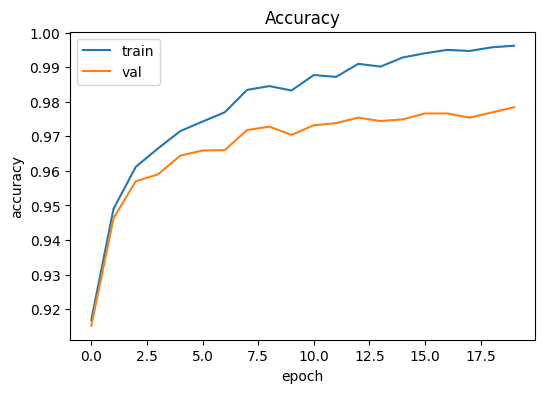

In [11]:
plt.figure(figsize=(6,4)); plt.plot(hist["tr_loss"], label="train"); plt.plot(hist["val_loss"], label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist["tr_acc"], label="train"); plt.plot(hist["val_acc"], label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend(); plt.show()


### Training and Validation Curves

The following plots show the **loss** and **accuracy** for both training and validation sets across 20 epochs:

- **Loss Curve**  
  Training loss decreases steadily, showing that the model is learning effectively.  
  Validation loss also decreases but stabilizes after ~8–10 epochs, suggesting the model has reached good generalization.

- **Accuracy Curve**  
  Training accuracy improves rapidly and approaches ~99%.  
  Validation accuracy rises smoothly and stabilizes around ~97–98%, which is typical for MNIST with this MLP.  
  The small gap between training and validation curves indicates slight overfitting, but overall the model generalizes well.

---

#### Interpretation
- The model successfully minimizes cross-entropy loss while increasing accuracy.  
- Training accuracy is slightly higher than validation accuracy, showing that the model has fit the training data slightly better.  
- Since validation accuracy is close to training accuracy, the model has not overfit severely and remains robust.  

These curves confirm that the NumPy-based MLP is capable of achieving strong performance on MNIST.


In [12]:
print(f"Training accuracy: {accuracy(model, X_train, y_train):.4f}")
print(f"Test accuracy:     {accuracy(model, X_test,  y_test):.4f}")


Training accuracy: 0.9962
Test accuracy:     0.9773


### Final Evaluation

After training for 20 epochs, the MLP model achieves the following results:

- **Training Accuracy**: 99.62%  
- **Test Accuracy**: 97.73%  

---

#### Interpretation
- The training accuracy is nearly perfect (~99.6%), which shows the model has learned the training set very well.  
- The test accuracy (~97.7%) confirms that the model generalizes effectively to unseen data.  
- The small gap (~1.9%) between training and test accuracy indicates **mild overfitting**, but the model remains robust and well-regularized.  

These results are competitive for a NumPy-only MLP implementation on MNIST, where typical accuracies range from **97–98%** without advanced optimizations.
